# Load packages and define functions

In [2]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [3]:
# Sorting code from Meng

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 9):  # initial maxTrys = 5
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [4]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set

    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    

        
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

# Preprocess MERFISH from MENG for cell type classify

In [13]:
from sklearn import preprocessing
#adata_mer = adata_mer

MOp_MERFISH_meng_preprocessed_for_integration_file =r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer/counts.h5ad'

merfish_raw = sc.read_h5ad(MOp_MERFISH_meng_preprocessed_for_integration_file)

In [6]:
merfish_label = pd.read_csv(r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer/cell_labels.csv', index_col=0)

In [7]:
merData = pd.DataFrame(merfish_raw.X, index = merfish_raw.obs.index, columns = merfish_raw.var.index)
labels = merfish_label.loc[merfish_label['label']!='-1']
merData

index,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Gad2,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.659448,0.000000,...,0.261892,0.262109,0.037601,0.010633,0.192950,0.079685,0.063194,0.613834,0.038716,0.000000
100001798412490480358118871918100400402,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.512115,0.225832,0.093828,0.000000,0.160687,0.171461,0.208027,0.618113,0.051407,0.000000
100006878605830627922364612565348097824,0.0,0.000000,0.0,0.000000,25.567039,0.0,0.000000,0.000000,0.000000,0.000000,...,0.199059,0.114653,0.000000,0.070231,0.144294,0.051351,0.148232,0.448829,0.041903,0.000000
100007228202835962319771548915451072492,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.240500,0.093413,0.033100,0.151837,0.197471,0.011399,0.110675,1.117577,0.016462,0.467554
100009332472089331948140672873134747603,0.0,0.491629,0.0,0.983257,0.491629,0.0,0.000000,0.000000,0.983257,0.000000,...,1.726676,0.533404,3.691514,0.000000,0.296567,0.748264,1.423427,11.386119,0.387408,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,0.0,0.000000,0.0,0.557620,0.000000,0.0,0.000000,0.000000,0.557620,2.788098,...,4.711612,1.145445,0.000000,0.362137,1.549598,0.195306,4.132728,1.586415,0.152228,8.515803
99989592830367590092304100078674096866,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.829112,14.632893,0.000000,...,0.354238,0.160562,0.630489,0.030634,0.073509,0.000000,0.210928,4.954309,0.140572,0.107833
99991756591196613545069880666241120777,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.944207,0.221704,0.139209,0.854429,0.296027,0.110999,0.432686,5.654802,0.042431,0.004518


In [8]:
labels

,sample_id,slice_id,class_label,subclass,label
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3
...,...,...,...,...,...
99987465505639073211021560543065098772,mouse1_sample5,mouse1_slice251,GABAergic,Pvalb,Pvalb_1
99989592830367590092304100078674096866,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_5
99991756591196613545069880666241120777,mouse1_sample3,mouse1_slice112,Glutamatergic,L4/5 IT,L45_IT_3
99997421766159526763299676887100858104,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_3


In [9]:
# merge dataframes
merCluster=merData.merge(labels, how='inner', left_index=True, right_index=True)
merCluster.shape

merCluster

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Sst,Rab3b,Slc17a7,Penk,Gad1,sample_id,slice_id,class_label,subclass,label
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.659448,0.000000,...,0.079685,0.063194,0.613834,0.038716,0.000000,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1
100001798412490480358118871918100400402,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.171461,0.208027,0.618113,0.051407,0.000000,mouse2_sample5,mouse2_slice160,Other,Endo,Endo
100006878605830627922364612565348097824,0.0,0.000000,0.0,0.000000,25.567039,0.0,0.000000,0.000000,0.000000,0.000000,...,0.051351,0.148232,0.448829,0.041903,0.000000,mouse2_sample6,mouse2_slice109,Other,SMC,SMC
100007228202835962319771548915451072492,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.011399,0.110675,1.117577,0.016462,0.467554,mouse1_sample2,mouse1_slice71,Other,Endo,Endo
100009332472089331948140672873134747603,0.0,0.491629,0.0,0.983257,0.491629,0.0,0.000000,0.000000,0.983257,0.000000,...,0.748264,1.423427,11.386119,0.387408,0.000000,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,0.0,0.000000,0.0,0.557620,0.000000,0.0,0.000000,0.000000,0.557620,2.788098,...,0.195306,4.132728,1.586415,0.152228,8.515803,mouse1_sample5,mouse1_slice251,GABAergic,Pvalb,Pvalb_1
99989592830367590092304100078674096866,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.829112,14.632893,0.000000,...,0.000000,0.210928,4.954309,0.140572,0.107833,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_5
99991756591196613545069880666241120777,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.110999,0.432686,5.654802,0.042431,0.004518,mouse1_sample3,mouse1_slice112,Glutamatergic,L4/5 IT,L45_IT_3


In [239]:
merCluster.iloc[:,:-5]

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Gad2,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.659448,0.000000,...,0.261892,0.262109,0.037601,0.010633,0.192950,0.079685,0.063194,0.613834,0.038716,0.000000
100001798412490480358118871918100400402,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.512115,0.225832,0.093828,0.000000,0.160687,0.171461,0.208027,0.618113,0.051407,0.000000
100006878605830627922364612565348097824,0.0,0.000000,0.0,0.000000,25.567039,0.0,0.000000,0.000000,0.000000,0.000000,...,0.199059,0.114653,0.000000,0.070231,0.144294,0.051351,0.148232,0.448829,0.041903,0.000000
100007228202835962319771548915451072492,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.240500,0.093413,0.033100,0.151837,0.197471,0.011399,0.110675,1.117577,0.016462,0.467554
100009332472089331948140672873134747603,0.0,0.491629,0.0,0.983257,0.491629,0.0,0.000000,0.000000,0.983257,0.000000,...,1.726676,0.533404,3.691514,0.000000,0.296567,0.748264,1.423427,11.386119,0.387408,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,0.0,0.000000,0.0,0.557620,0.000000,0.0,0.000000,0.000000,0.557620,2.788098,...,4.711612,1.145445,0.000000,0.362137,1.549598,0.195306,4.132728,1.586415,0.152228,8.515803
99989592830367590092304100078674096866,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.829112,14.632893,0.000000,...,0.354238,0.160562,0.630489,0.030634,0.073509,0.000000,0.210928,4.954309,0.140572,0.107833
99991756591196613545069880666241120777,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.944207,0.221704,0.139209,0.854429,0.296027,0.110999,0.432686,5.654802,0.042431,0.004518


In [14]:
# Scale variable measurements for model training
merGroupedDataZ = pd.DataFrame(preprocessing.scale(merCluster.iloc[:,:-5]),index = merCluster.iloc[:,:-5].index, columns = merCluster.iloc[:,:-5].columns)

merGroupedDataZ['subclass'] = merCluster.iloc[:,-2]

C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [15]:
merGroupedDataZ

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1,subclass
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.348175,-0.274825,...,-0.384528,-0.483580,-0.246400,-0.346832,-0.126652,-0.780719,-0.971601,-0.381083,-0.245849,Astro
100001798412490480358118871918100400402,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.481826,-0.447294,-0.255495,-0.383033,-0.095295,-0.624110,-0.970920,-0.364425,-0.245849,Endo
100006878605830627922364612565348097824,-0.14432,-0.270846,-0.161999,-0.222231,5.728458,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.780022,-0.507845,-0.195420,-0.401427,-0.136333,-0.688766,-0.997852,-0.376900,-0.245849,SMC
100007228202835962319771548915451072492,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.836989,-0.486484,-0.125615,-0.341760,-0.149984,-0.729377,-0.891460,-0.410295,-0.111492,Endo
100009332472089331948140672873134747603,-0.14432,1.116969,-0.161999,3.536333,-0.110647,-0.215885,-0.305883,-0.257521,-0.264185,-0.274825,...,0.343120,1.874451,-0.255495,-0.230569,0.101786,0.690105,0.742187,0.076623,-0.245849,L2/3 IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,-0.14432,-0.270846,-0.161999,1.909306,-0.225128,-0.215885,-0.305883,-0.257521,-0.374588,1.675924,...,1.984689,-0.507845,0.054276,1.175393,-0.087147,3.619679,-0.816871,-0.232083,2.201252,Pvalb
99989592830367590092304100078674096866,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,0.092527,3.276286,-0.274825,...,-0.656887,-0.100963,-0.229291,-0.480851,-0.153879,-0.620974,-0.281065,-0.247383,-0.214862,L5 ET
99991756591196613545069880666241120777,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.492898,-0.418007,0.475379,-0.231175,-0.115953,-0.381186,-0.169621,-0.376207,-0.244550,L4/5 IT


In [16]:

adata_ref = merGroupedDataZ

# exclude the last label column for X training
adata_ref.iloc[:,:-1]

adata_ref['subclass']

index
10000143038275111136124942858811168393       Astro
100001798412490480358118871918100400402       Endo
100006878605830627922364612565348097824        SMC
100007228202835962319771548915451072492       Endo
100009332472089331948140672873134747603    L2/3 IT
                                            ...   
99987465505639073211021560543065098772       Pvalb
99989592830367590092304100078674096866       L5 ET
99991756591196613545069880666241120777     L4/5 IT
99997421766159526763299676887100858104       L5 ET
99997470167777465101376150817407669505     L2/3 IT
Name: subclass, Length: 280186, dtype: object

# Load nonclear MERFISH data

In [19]:
MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
#MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
adata_mer_2 = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)

adata_query = adata_mer_2

# Train classifer

In [20]:
adata_query = adata_mer_2

genes_from_ref = set(merData.columns)
genes = list(genes_from_ref.intersection(set(adata_query.var.index)))


# Train a classifier
gene_ids = [merData.columns.get_loc(g) for g in genes]

print('Train cell type classifier.')

X = np.array(adata_ref.iloc[:,:-1])[:, gene_ids]
Y = np.array(adata_ref['subclass'])
nnc = MLPClassifier(max_iter = 500)
nnc.fit(X, Y)



Train cell type classifier.


MLPClassifier(max_iter=500)

In [21]:
nnc

MLPClassifier(max_iter=500)

In [ ]:
_score = nnc.score(X=adata_query.X, y=adata_query.obs['ref_cluster_column'])
_score

In [24]:
np.unique(adata_ref['subclass'])

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype=object)

In [25]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L6 IT Car3','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','PVM','other']

# Predict nonclear MERFISH data

Predict cell types.


<ipython-input-26-f7f40d3fbe63>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


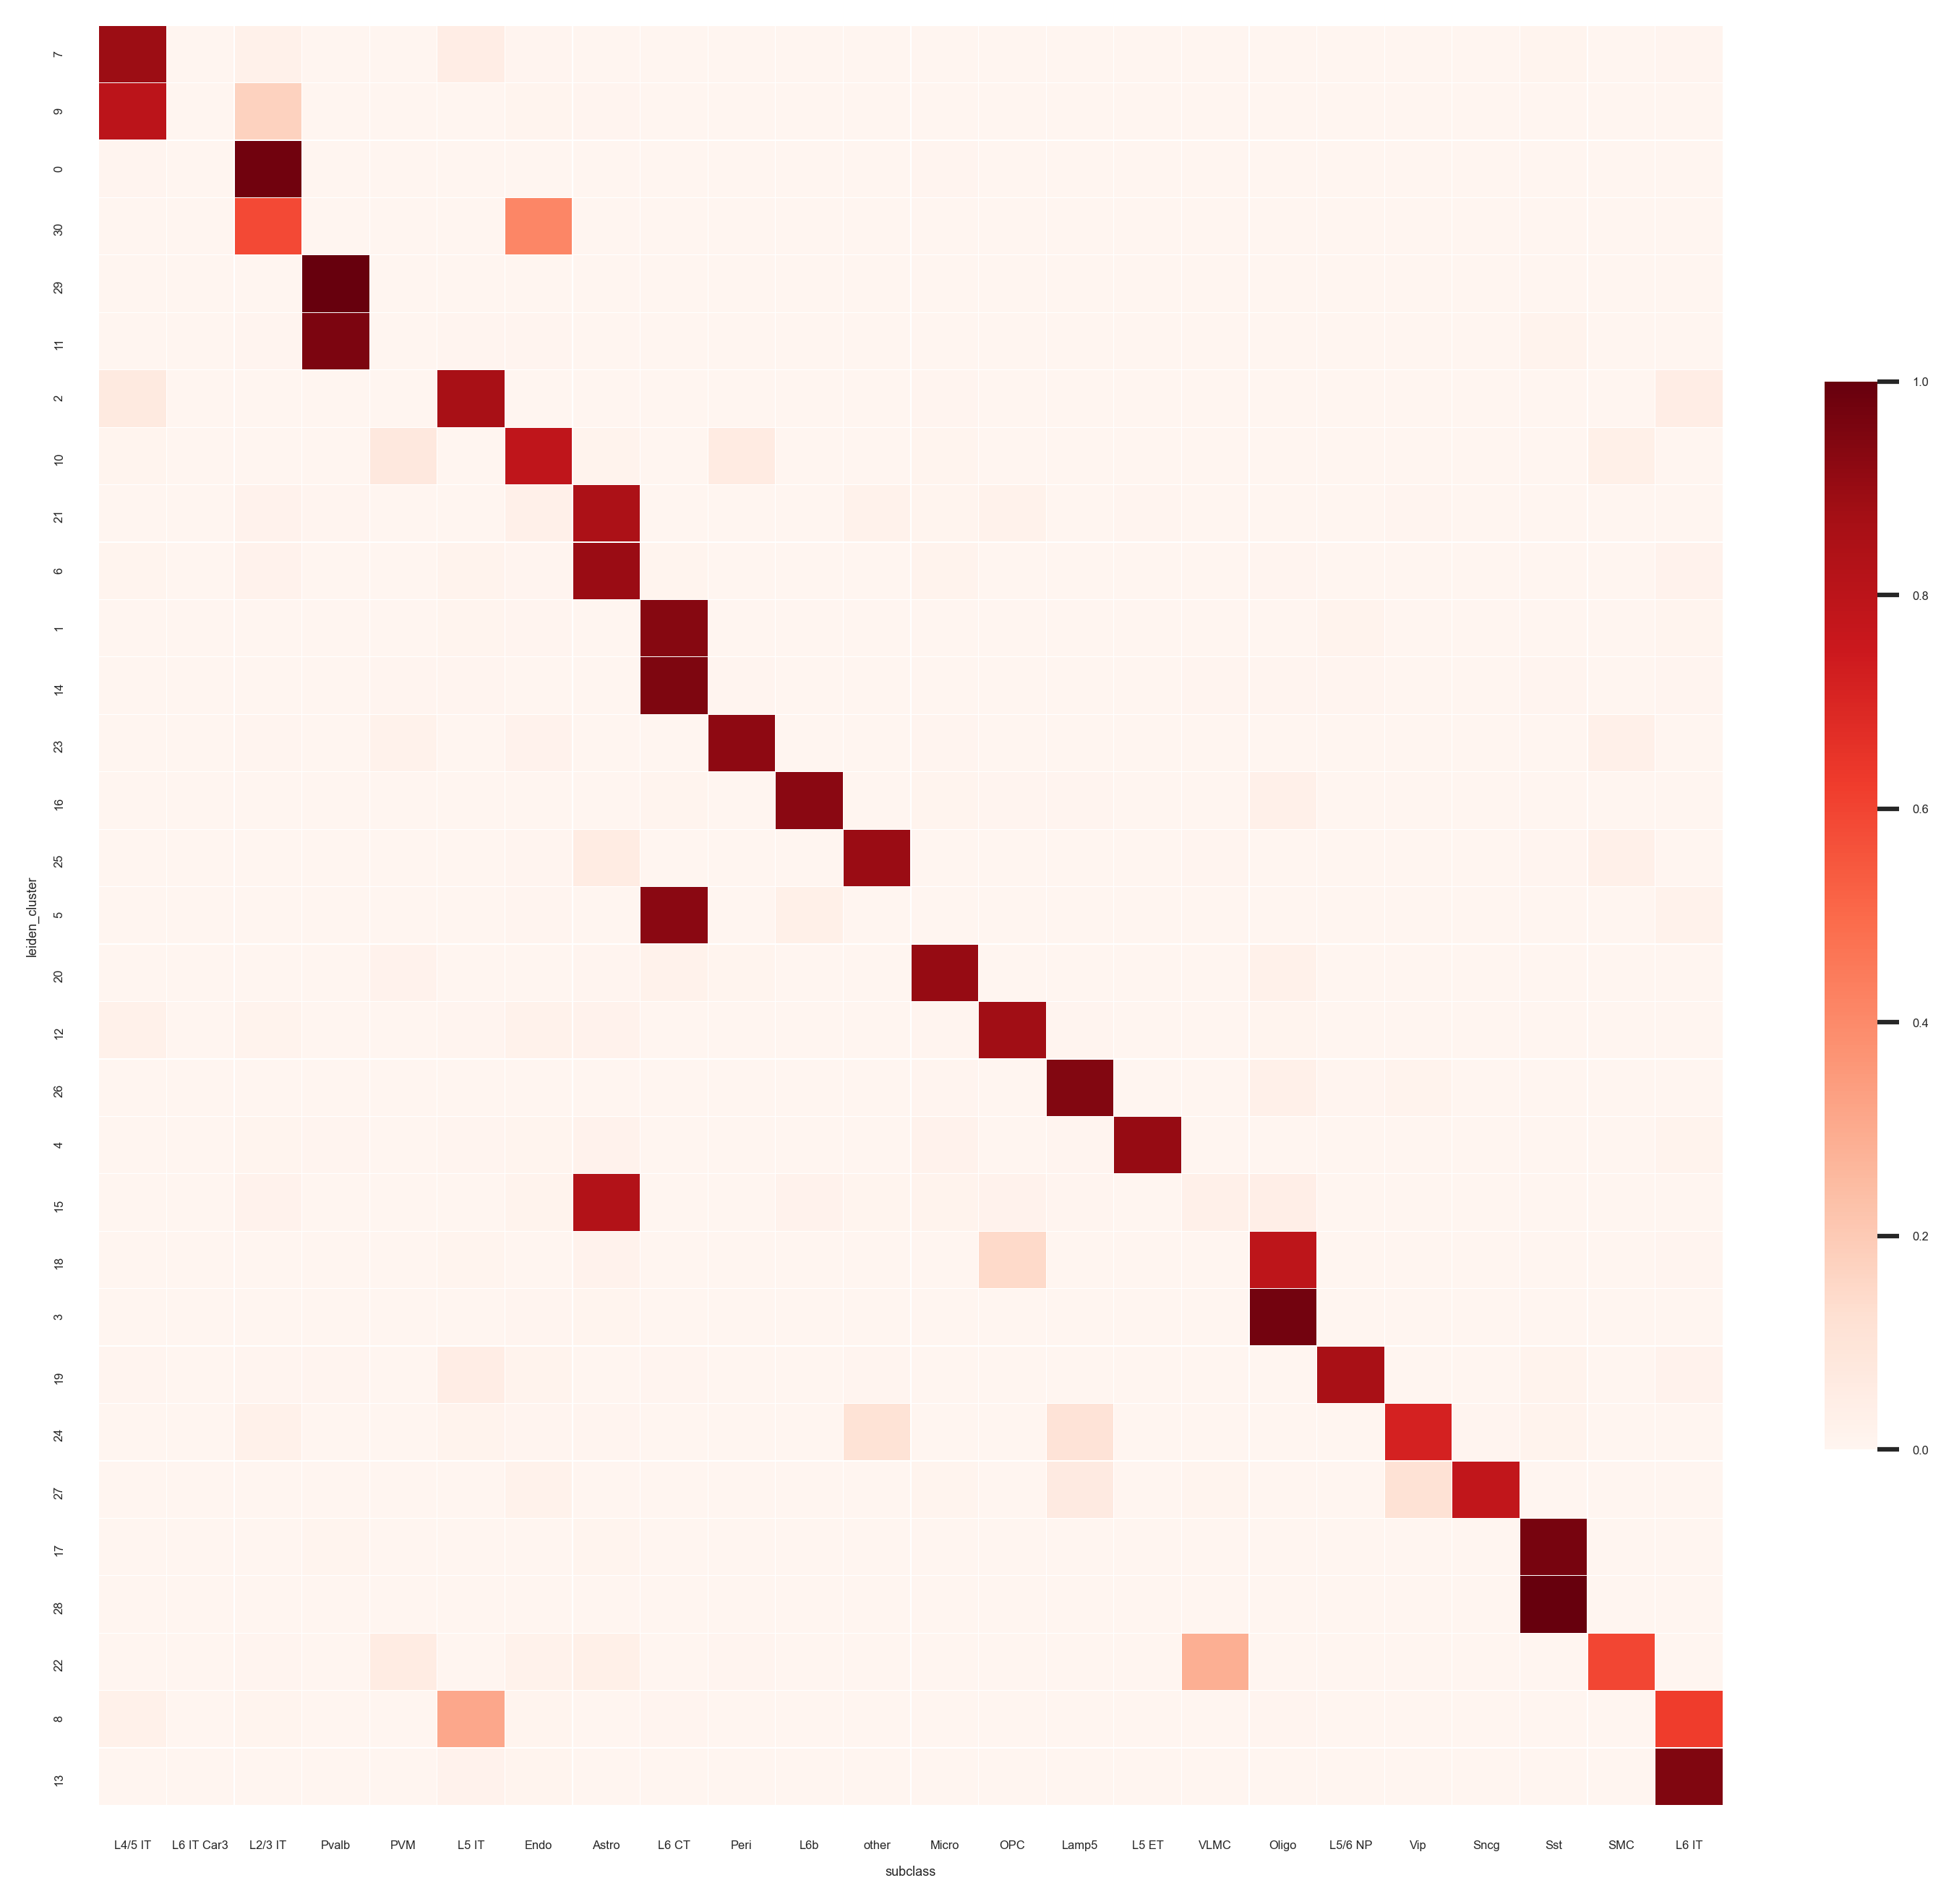

In [26]:
prediction_column = 'ref_cluster_column'

ref_cluster_column = 'subclass'

#query_cluster_column = 'leiden_subclass'
query_cluster_column = 'leiden_cluster'



print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.show()

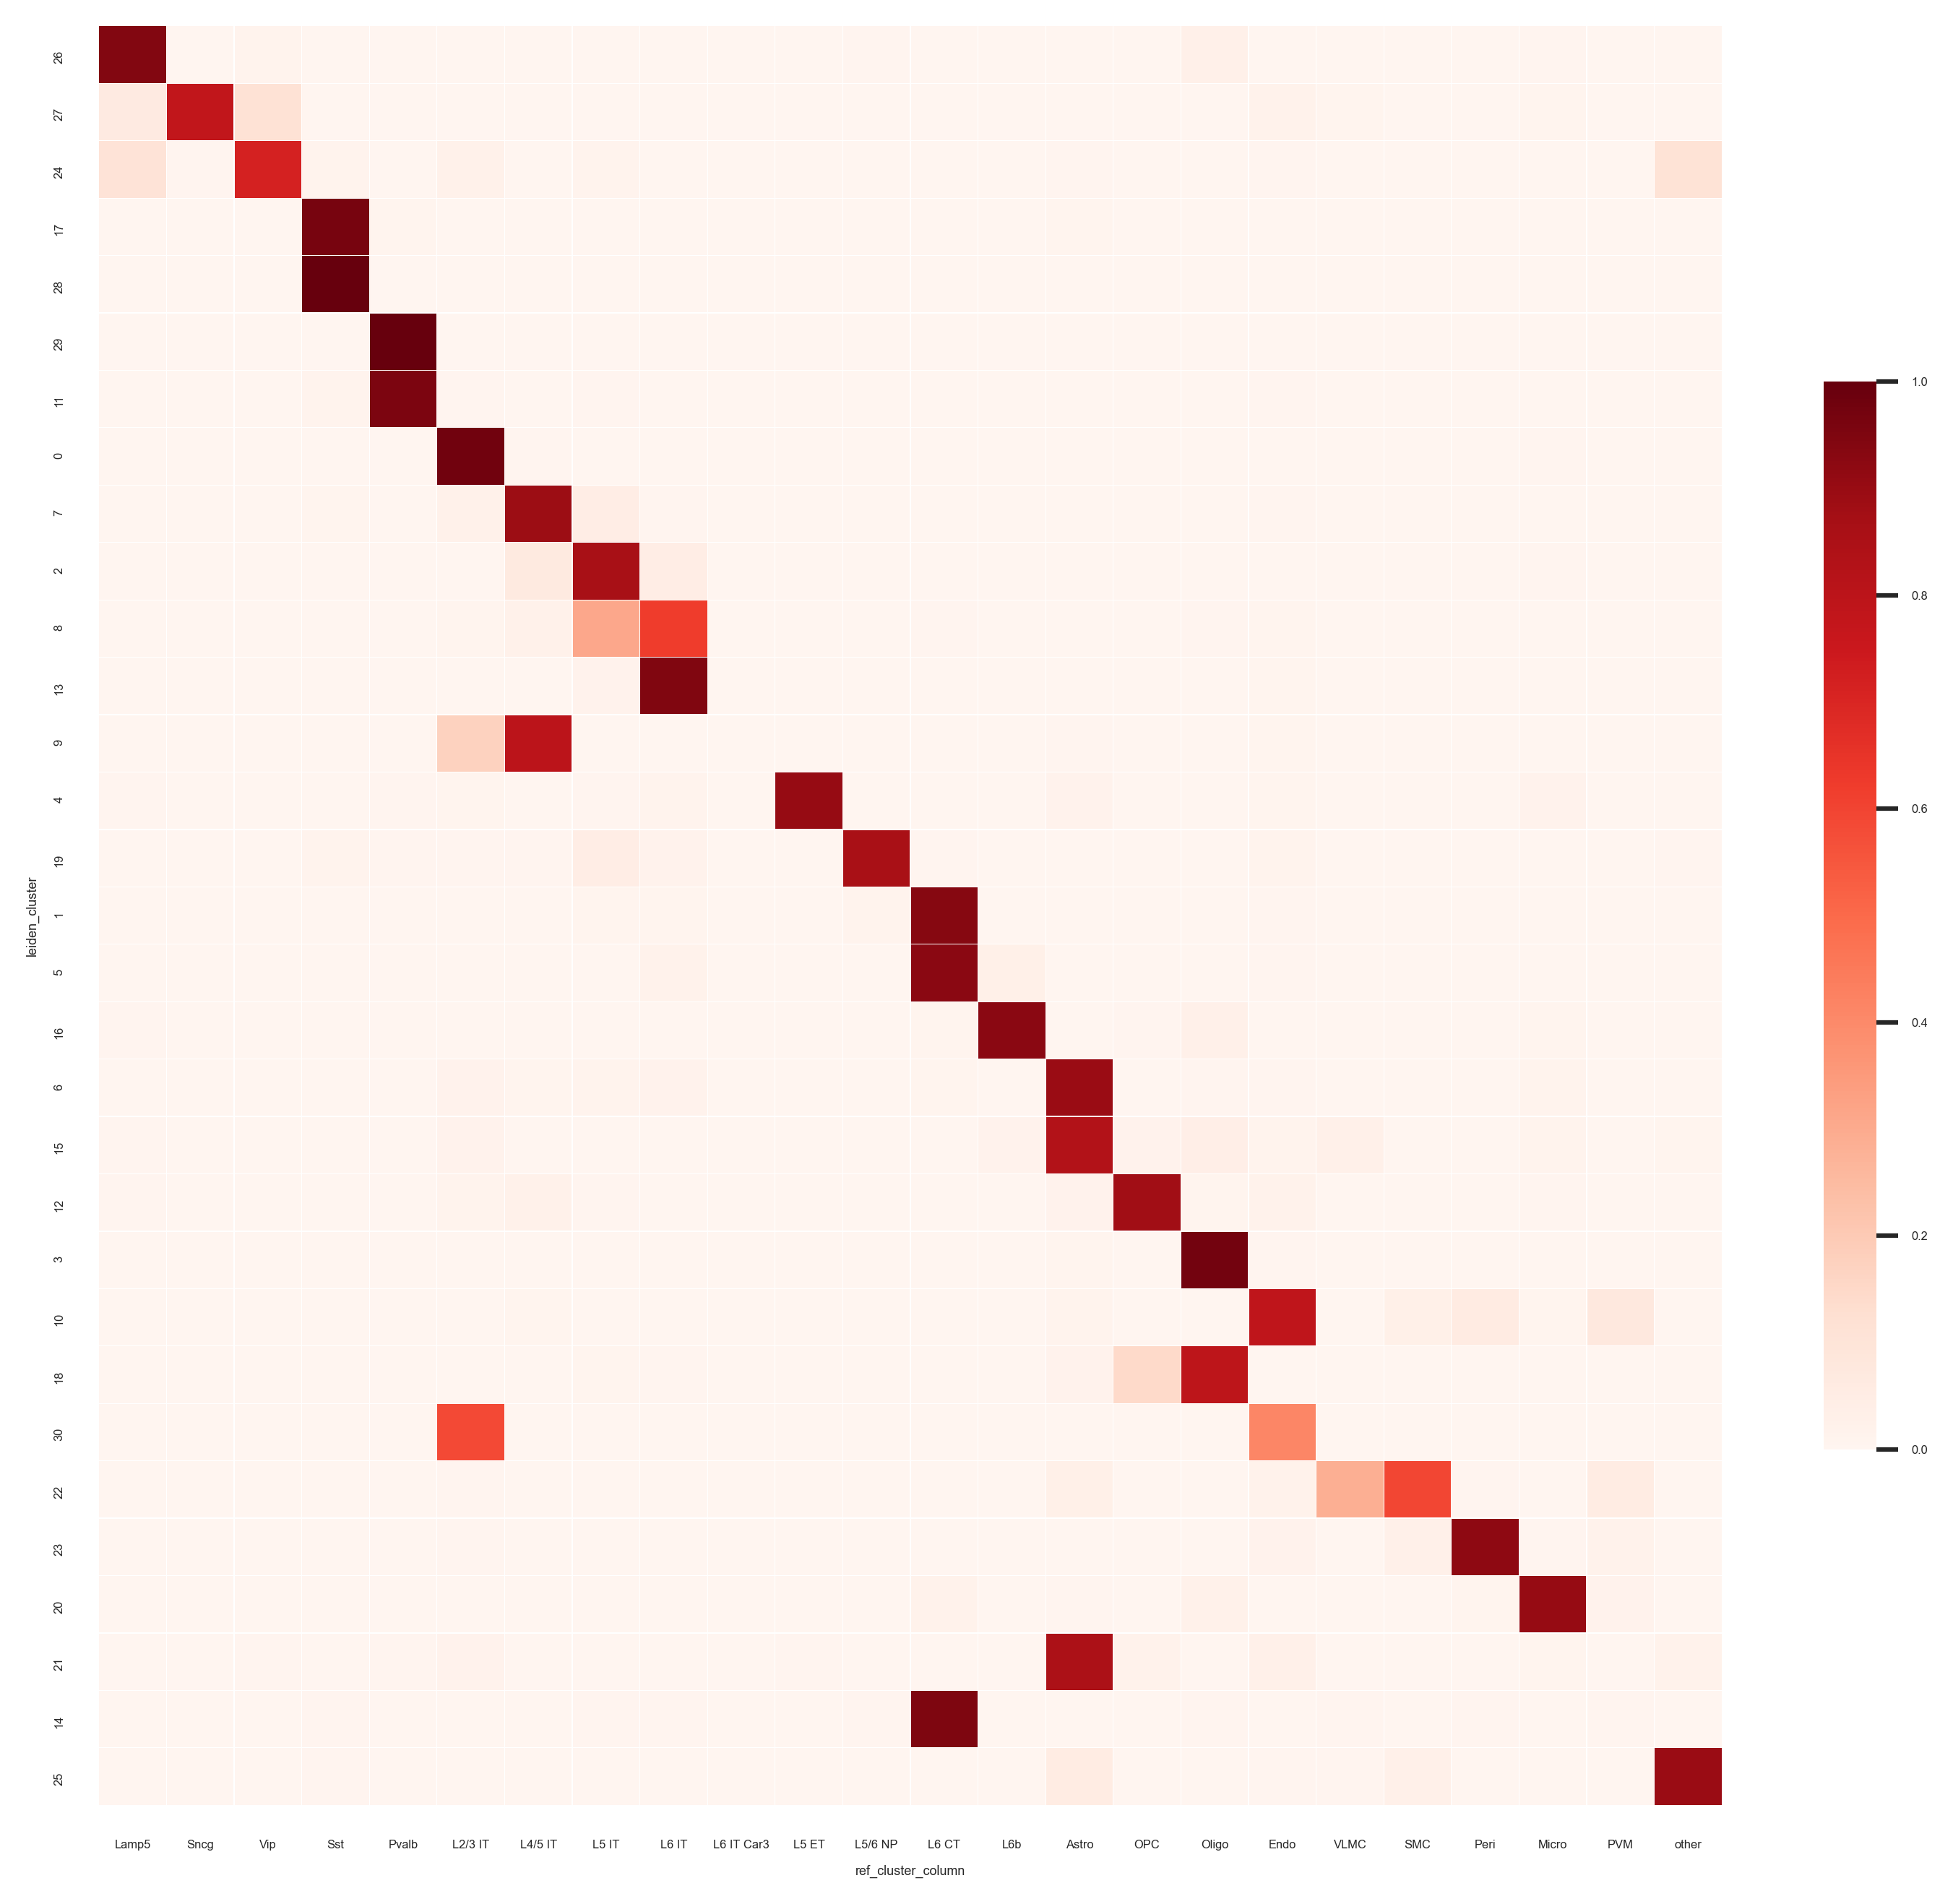

In [27]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L6 IT Car3','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','PVM','other']

fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.show()

In [34]:
leiden_index= list(sorted_coor_df.index)

len(leiden_index)

len(['26', '27', '24', '17','28','29','11','0','9','7','2','8','13',
                                        '4','19','1','5','14','16','6','15','21','12','18','3','10','22','23','20','25',
                                        '30'])

31

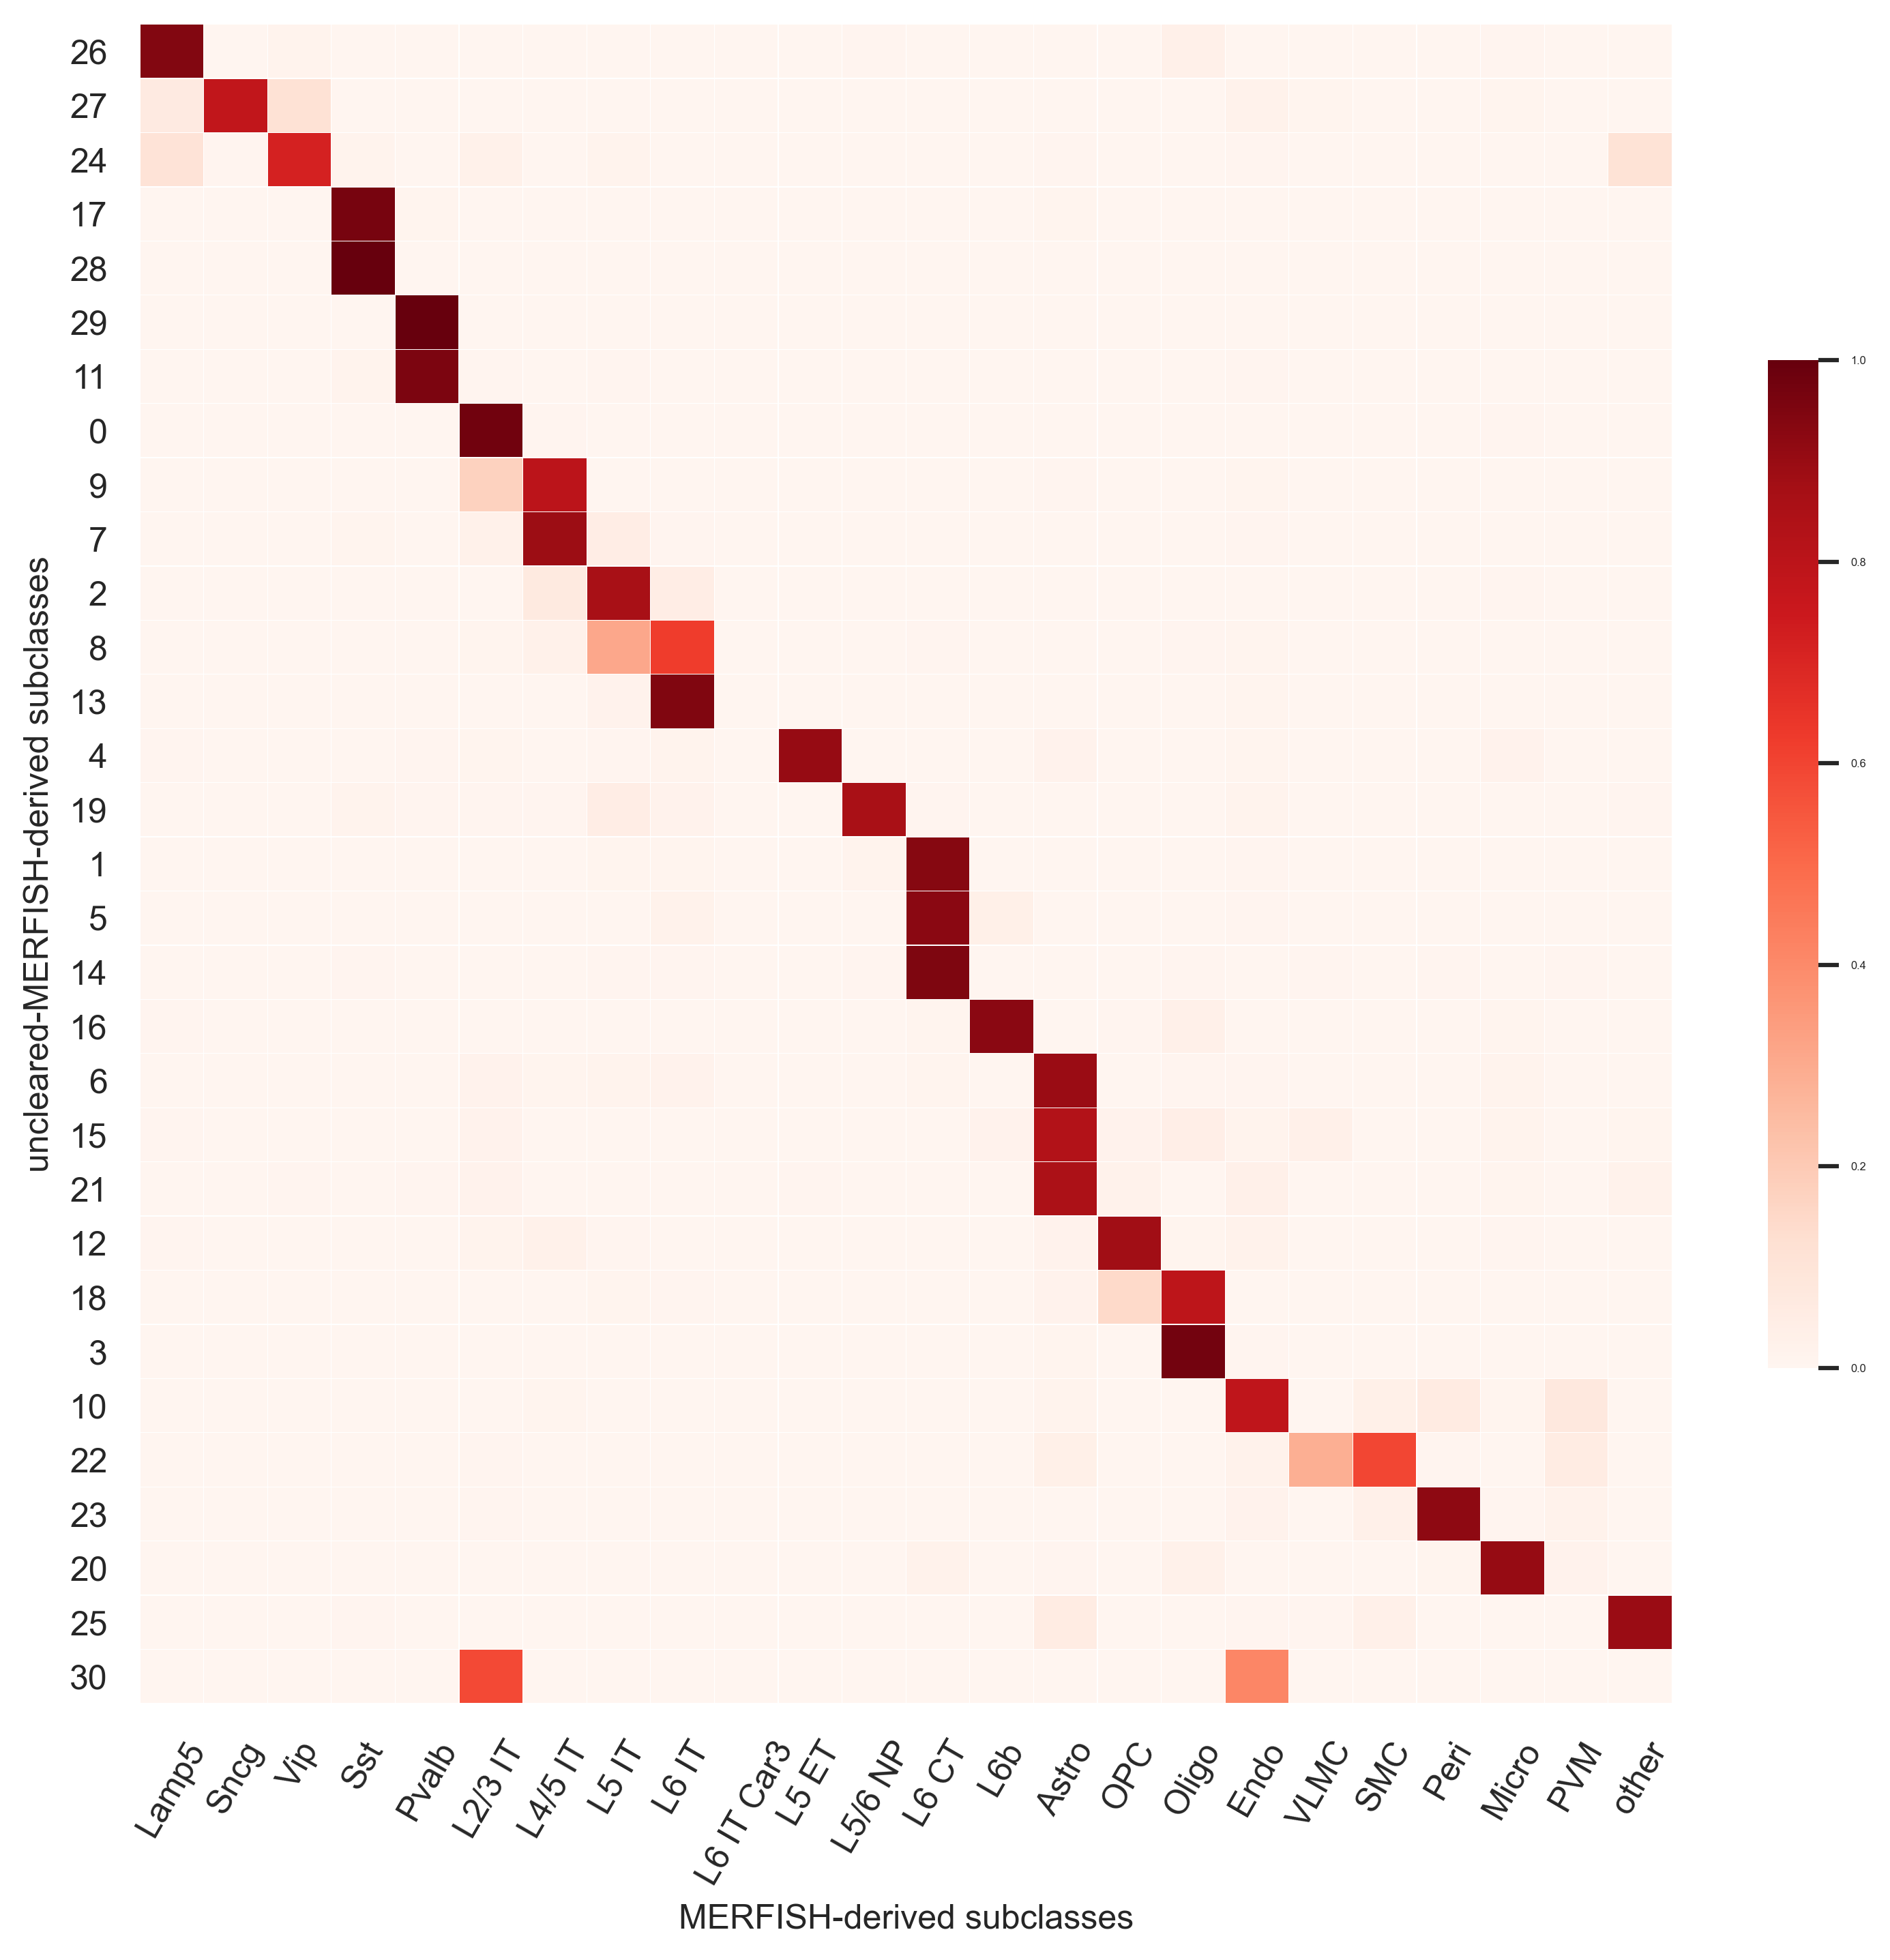

In [33]:
manual_coor_df = sorted_coor_df.reindex(['26', '27', '24', '17','28','29','11','0','9','7','2','8','13',
                                        '4','19','1','5','14','16','6','15','21','12','18','3','10','22','23','20','25',
                                        '30'])


if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel('MERFISH-derived subclasses',fontsize=10)
    plt.ylabel('uncleared-MERFISH-derived subclasses',fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    plt.show()

In [ ]:
# Load re-annotated data

In [35]:
# MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230_sub.h5ad'
adata_mer_3 = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)

adata_query = adata_mer_3

Predict cell types.


<ipython-input-37-c5dcff888491>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


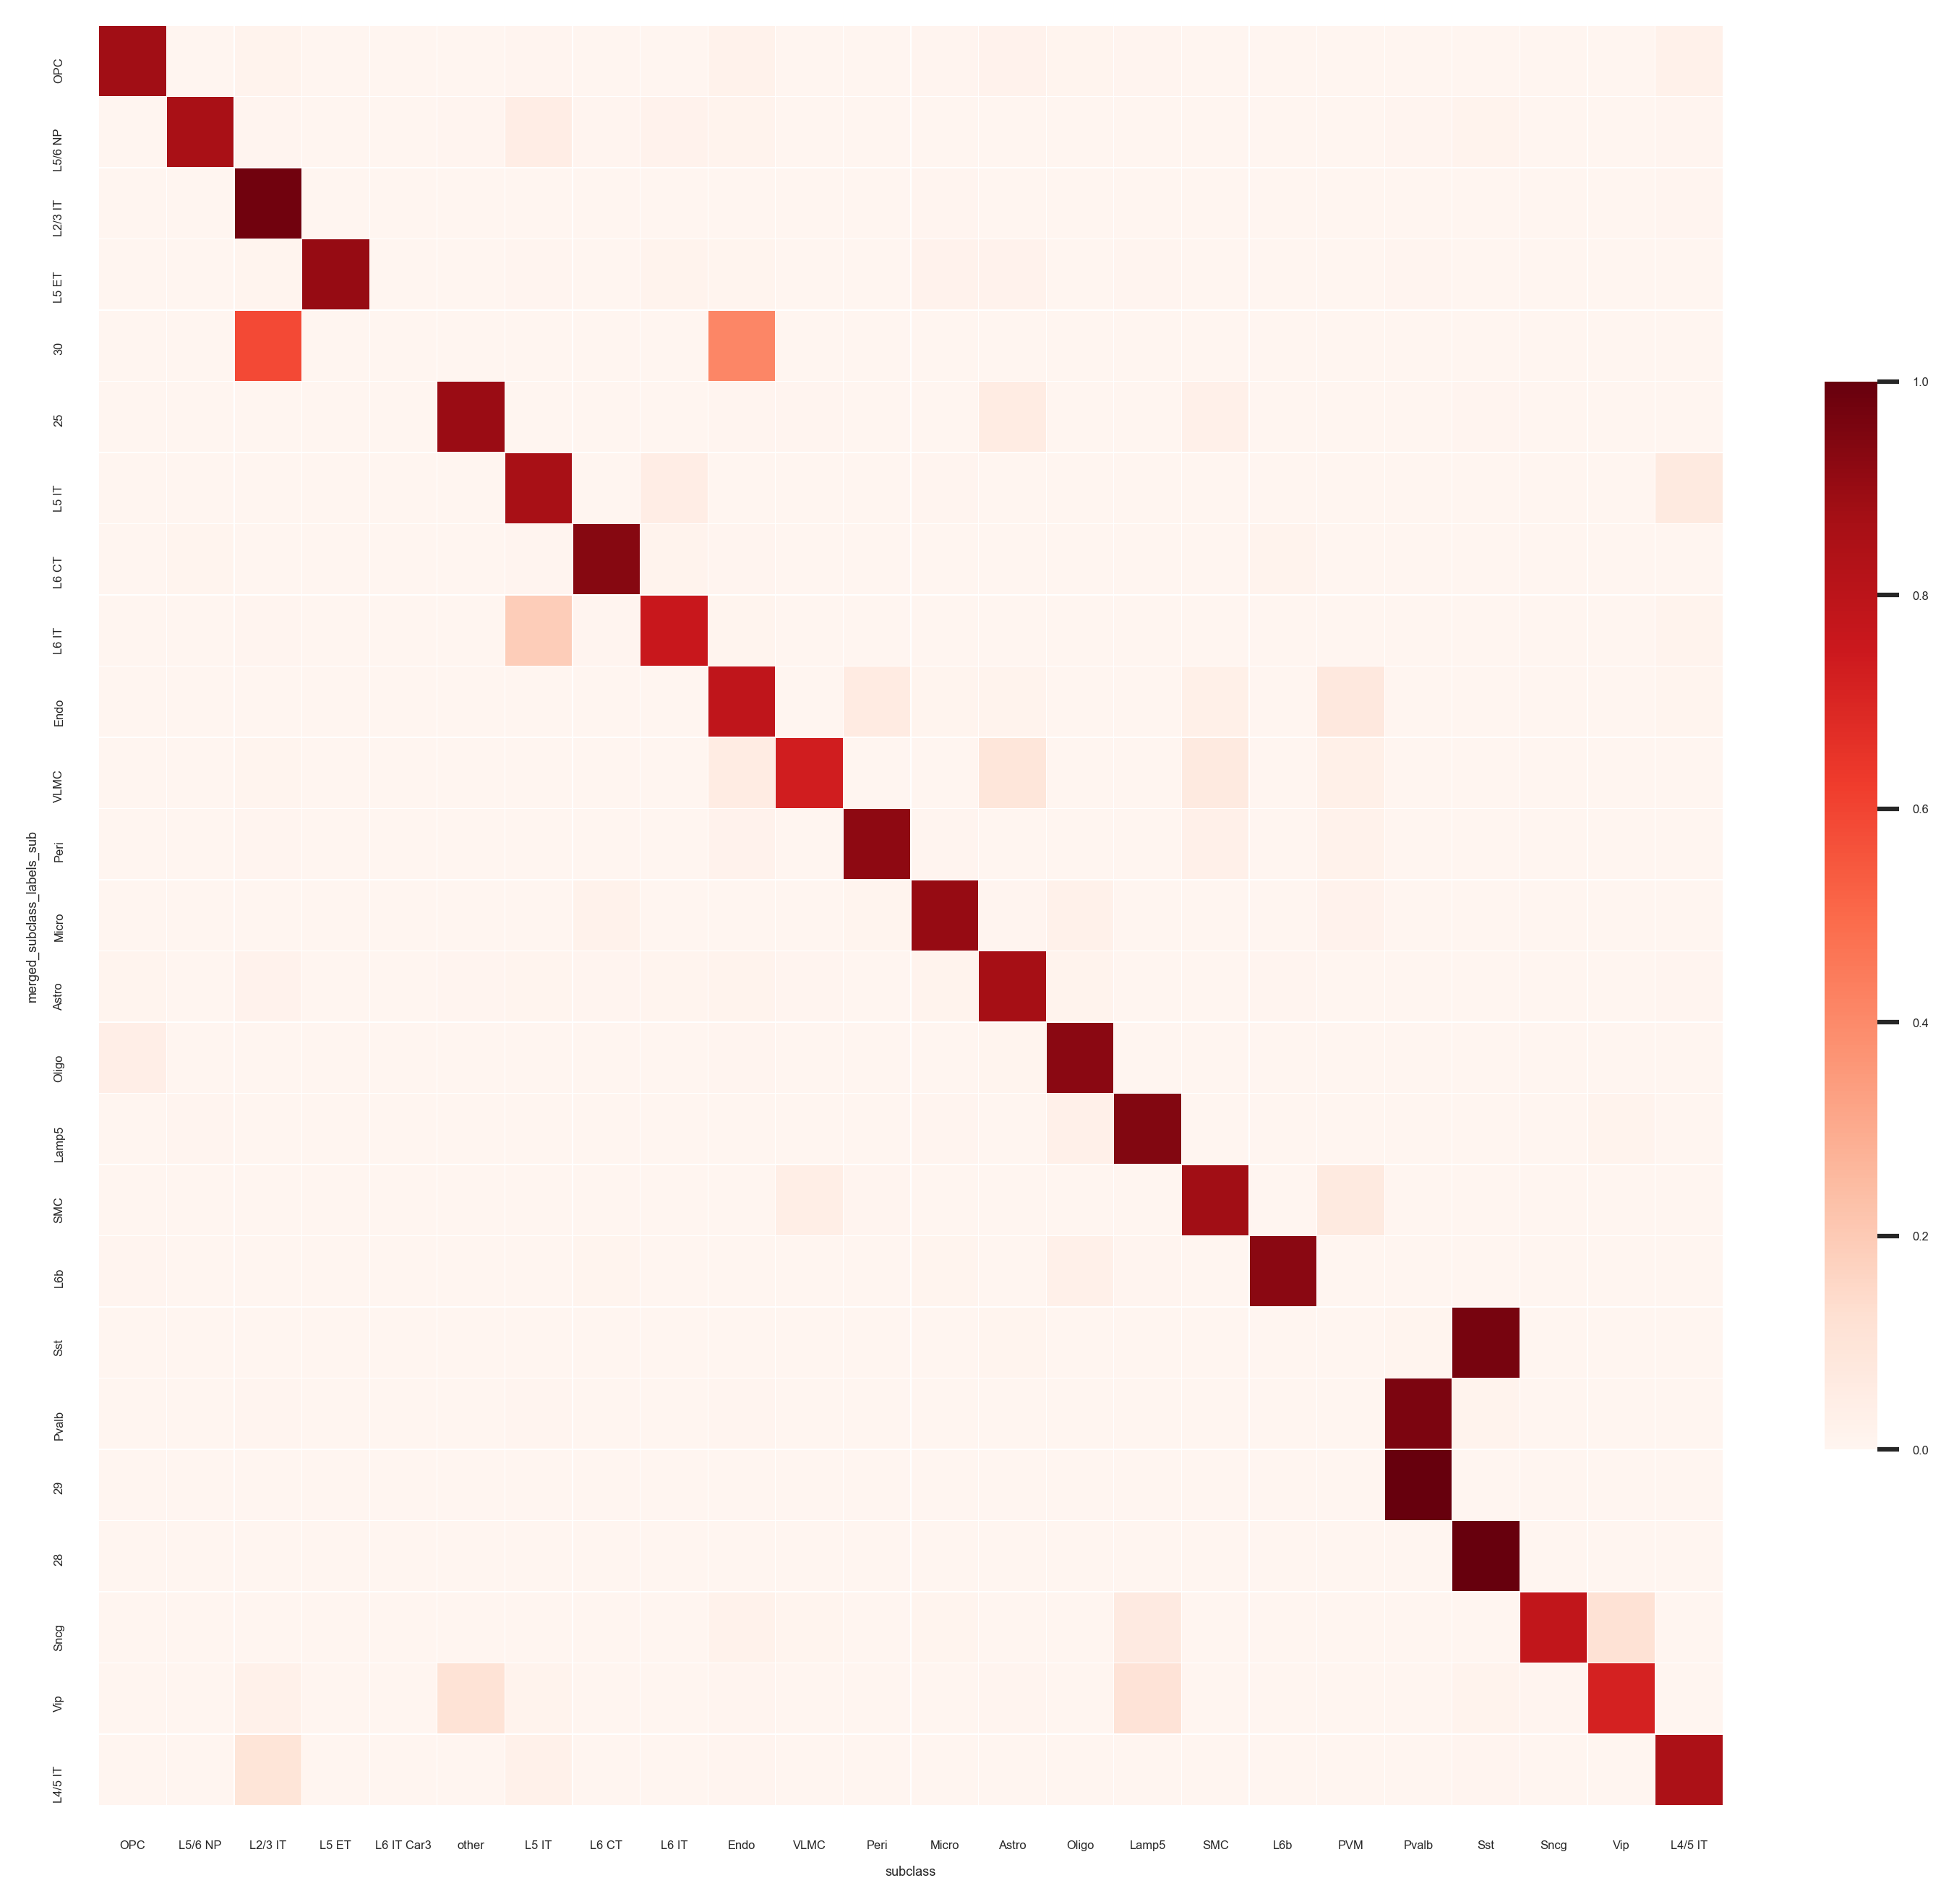

In [37]:
prediction_column = 'ref_cluster_column'

ref_cluster_column = 'subclass'

#query_cluster_column = 'leiden_subclass'
query_cluster_column = 'merged_subclass_labels_sub'



print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.show()

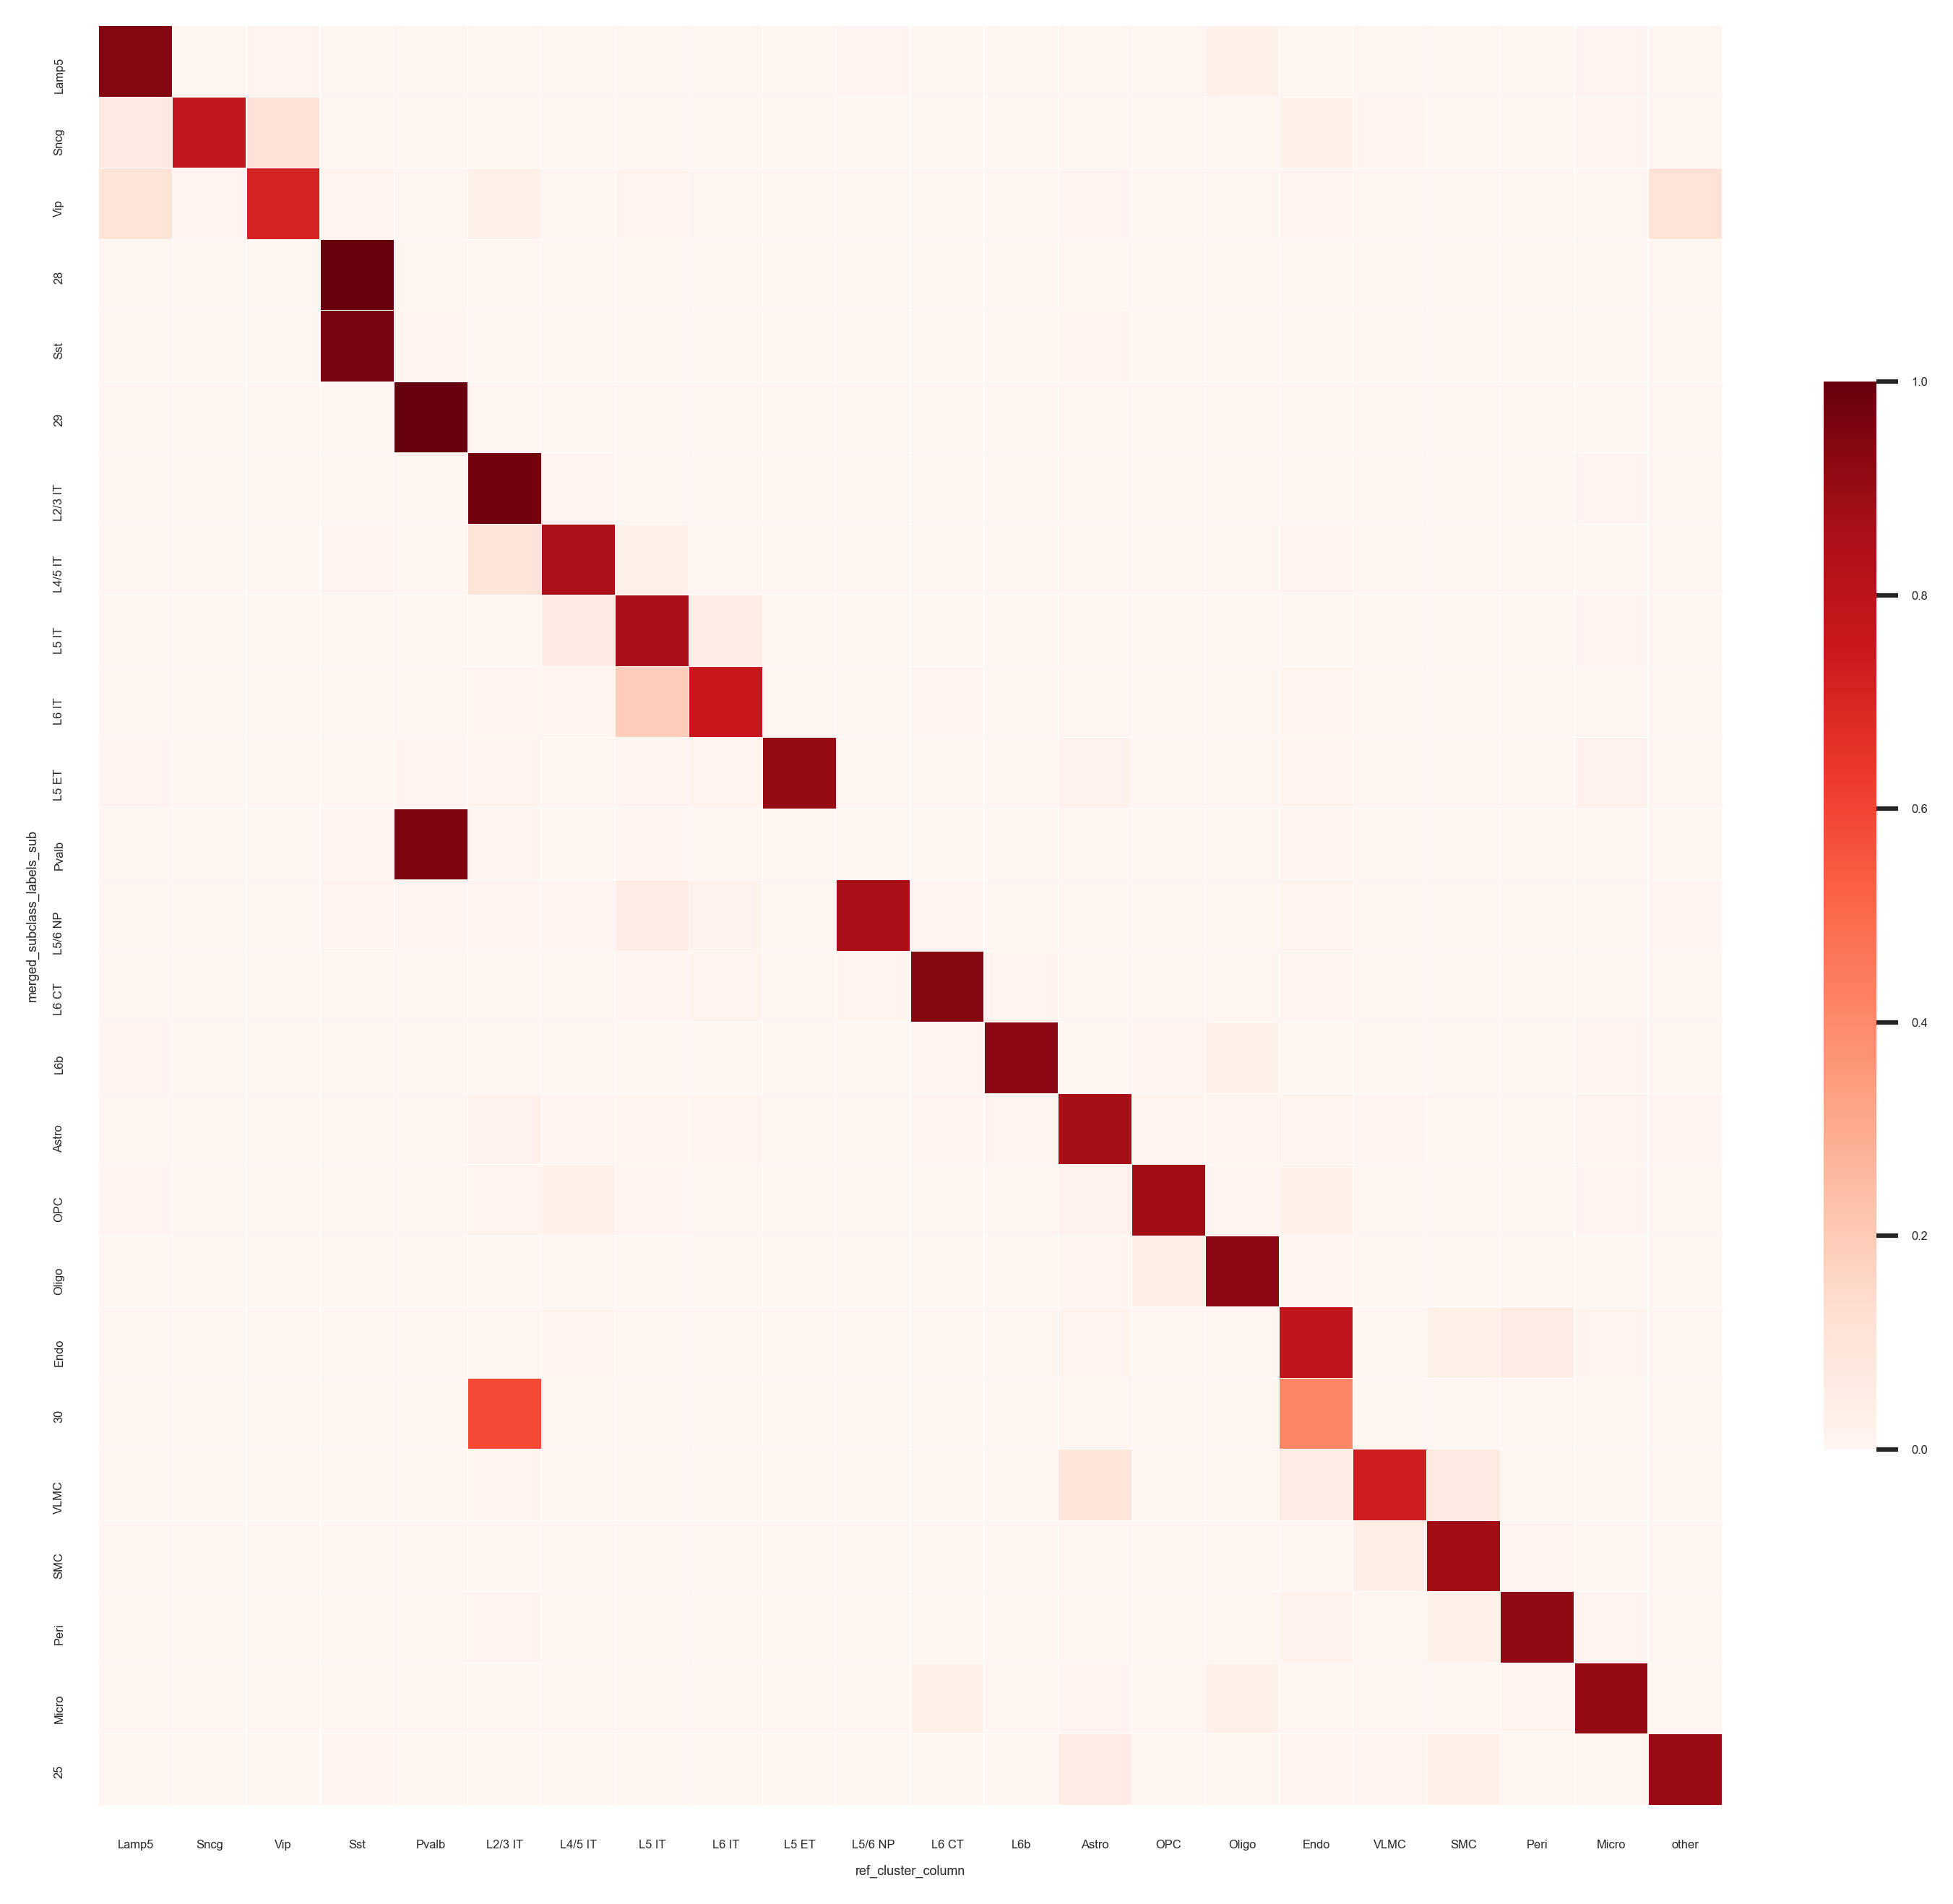

In [38]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','other']

fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.show()

In [40]:
sorted_coor_df.index

CategoricalIndex(['Lamp5', 'Sncg', 'Vip', '28', 'Sst', '29', 'L2/3 IT',
                  'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET', 'Pvalb', 'L5/6 NP',
                  'L6 CT', 'L6b', 'Astro', 'OPC', 'Oligo', 'Endo', '30',
                  'VLMC', 'SMC', 'Peri', 'Micro', '25'],
                 categories=['25', '28', '29', '30', 'Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', ...], ordered=False, name='merged_subclass_labels_sub', dtype='category')

In [ ]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','other']

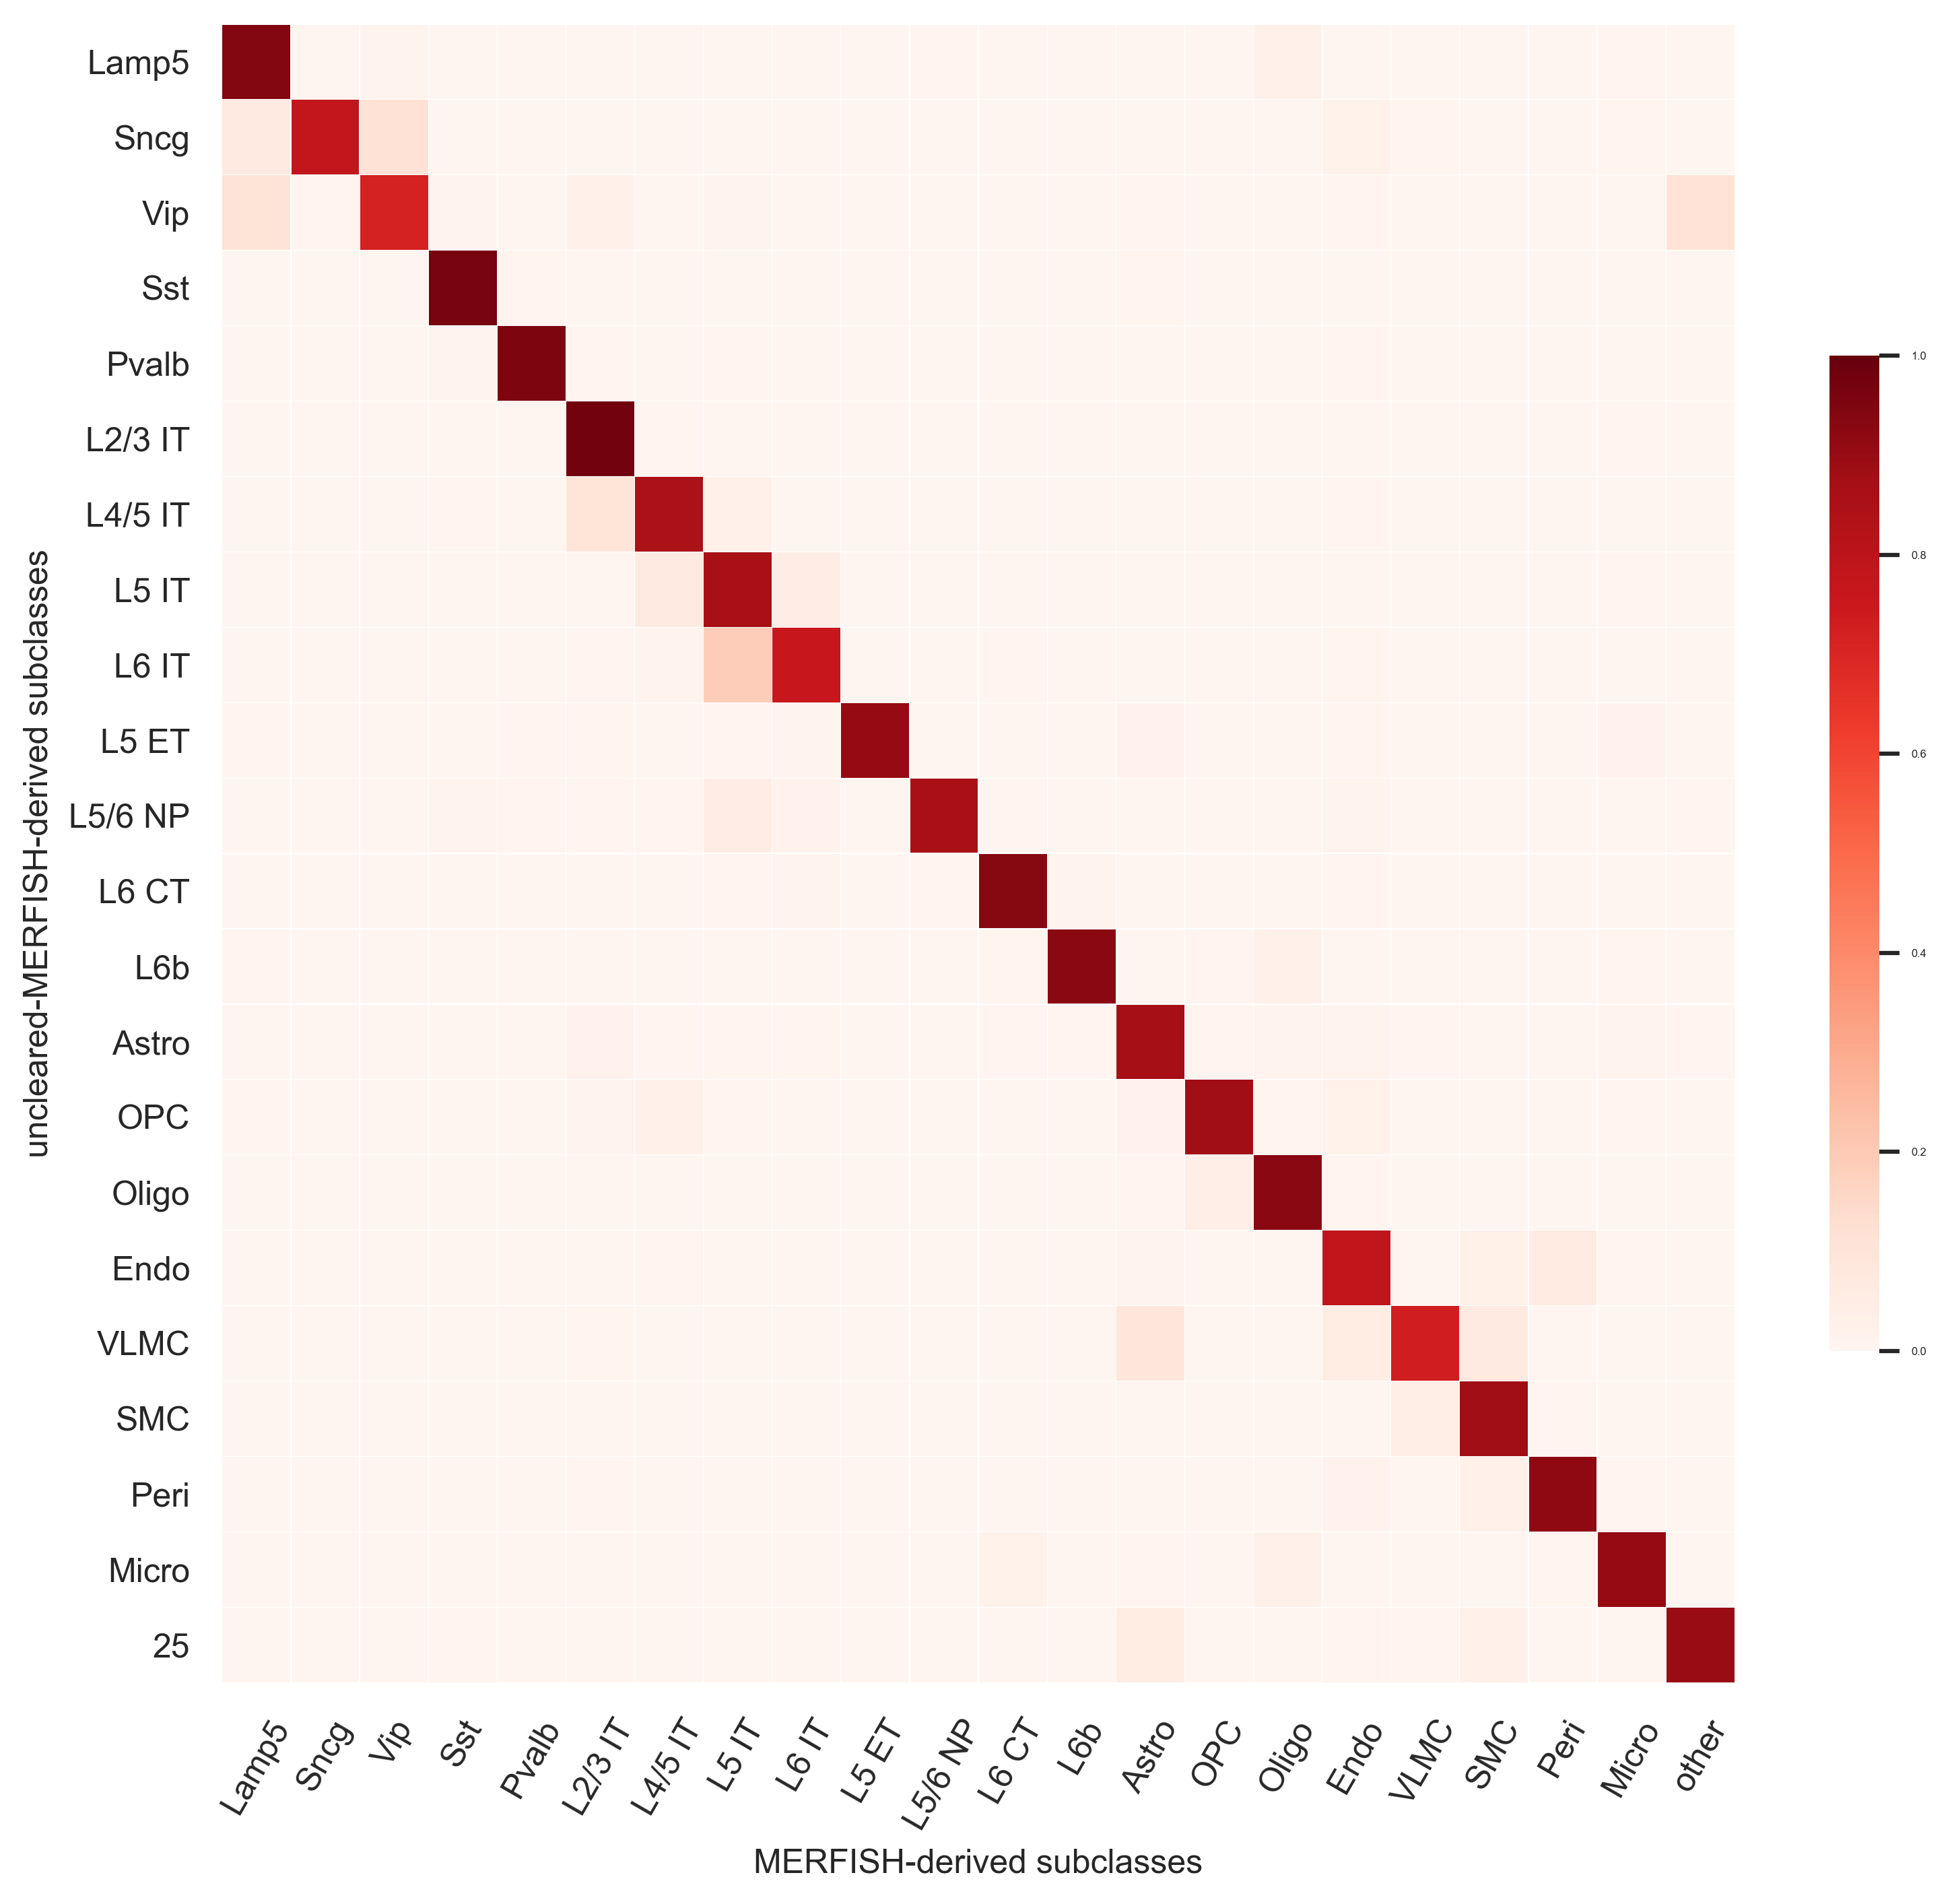

In [43]:
manual_coor_df = sorted_coor_df.reindex(['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','25'])


if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel('MERFISH-derived subclasses',fontsize=10)
    plt.ylabel('uncleared-MERFISH-derived subclasses',fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    plt.show()

In [44]:
np.max(manual_matrix, axis=1)

NameError: name 'manual_matrix' is not defined

In [46]:
manual_matrix = manual_coor_df.to_numpy()
print(manual_matrix.shape)


max_cluster_sum = np.sum(np.max(manual_matrix, axis=1))

sum_of_all_elements = manual_matrix.sum()
max_cluster_sum/sum_of_all_elements

(22, 22)


0.8840664984371182